In [1]:
!pip install p3_data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [3]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Load result files from P3 Test Driver
src_files = []
src_files += ['../../no_netty_comparison/low_cpu_18tests/low_cpu_18tests/p3_test_driver/results/*.json']
#src_files += ['../../no_netty_comparison/data/p3_test_driver/results/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 18 files...


In [6]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [7]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [8]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [9]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'kubernetes', 'localWorker', 'max_test_attempts',
       'noop', 'numWorkers', 'omb_results', 'omb_workers', 'output',
       'print_output', 'record_utc', 'record_uuid', 'result_filename',
       'run_as_test', 'sequence_in_test_batch', 'size_of_test_batch',
       'ssh_host', 'ssh_identity_file', 'ssh_user', 'status_html',
       'tarball', 'terraform', 'terraform_show', 'test', 'test_attempt',
       'test_batch_uuid', 'test_desc', 'test_driver_log_filename',
       'test_driver_version', 'test_uuid', 'undeploy', 'utc_begin',
       'utc_end', 'loaded_filename', 'driverName',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', '

In [10]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [11]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [12]:
cols = param_cols + output_cols

In [13]:
# View most recent results
clean_df[cols].tail(3).T

test_uuid,0f0874be-c493-45a6-acca-44bd16bb4dea,fe961d41-1581-4f81-a832-ebeb752f49e8,6f4675d0-c3f3-46e1-80fd-6ccbf216aaca
numWorkloadWorkers,2,2,2
topics,1,1,1
partitionsPerTopic,1,1,1
producersPerTopic,1,1,1
subscriptionsPerTopic,1,1,1
consumerPerSubscription,1,1,1
testDurationMinutes,1,1,1
keyDistributor,NO_KEY,NO_KEY,NO_KEY
git_commit,329cd9c,cba95af,cba95af
pravegaVersion,0.8.0-2508.30406cf,0.8.0-2508.30406cf,0.8.0-2508.30406cf


In [14]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [15]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [16]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

pravegaVersion
0.8.0-2508.30406cf    18
dtype: int64

In [17]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=1,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

18

In [19]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [20]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = 'Message Size %d' % (messageSize)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [21]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=1,
    partitionsPerTopic=1,
)

In [22]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid,2feaa9e8-105f-4cdc-afa8-7bab1a86be32


In [23]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,9d017fc7-a3be-4e7d-b623-9577bc814363
numWorkloadWorkers,2
topics,1
partitionsPerTopic,1
producersPerTopic,1
subscriptionsPerTopic,1
consumerPerSubscription,1
testDurationMinutes,1
keyDistributor,NO_KEY
git_commit,329cd9c
pravegaVersion,0.8.0-2508.30406cf


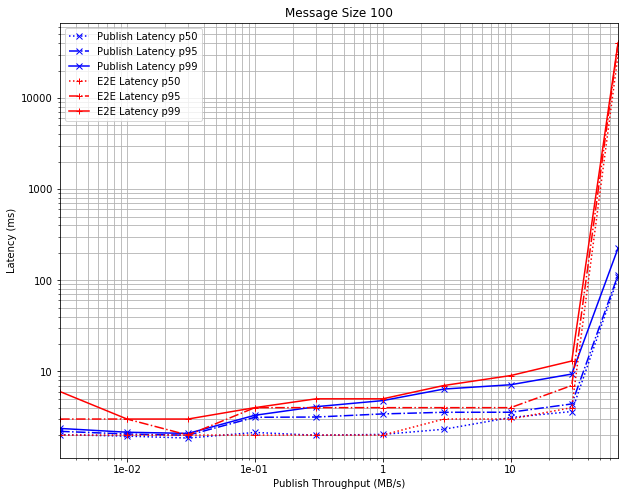

In [24]:
plot_latency_vs_throughput(filt_100_df)

In [25]:
latency_vs_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.003005,2.020,2.198,2.366,2.000,3.000,6.000,9d017fc7-a3be-4e7d-b623-9577bc814363
0.010022,1.947,2.054,2.149,2.000,3.000,3.000,d93d2342-ae4c-4d8f-8fe1-3d89253e506f
0.030065,1.856,1.992,2.086,2.000,2.000,3.000,d116aab9-ff02-4f04-a804-36789f71ca24
0.100218,2.136,3.136,3.299,2.000,4.000,4.000,21b64e51-fb55-4101-8985-d6fdfaa566b7
0.301533,1.992,3.155,4.098,2.000,4.000,5.000,e90ff066-fee1-4888-963e-a7c18300523d
1.002137,2.035,3.414,4.780,2.000,4.000,5.000,e35becd8-7c5f-43b9-b3d3-e63ce55ed306
3.008994,2.316,3.558,6.400,3.000,4.000,7.000,51f3cbb2-9ff8-488c-95fe-100dbc5b1efc
10.020727,3.120,3.562,7.135,3.000,4.000,9.000,2feaa9e8-105f-4cdc-afa8-7bab1a86be32
30.104122,3.624,4.393,9.348,4.000,7.000,13.000,806a96d1-6e5b-42fb-bd21-d873b7dfe34e


## Message Size 10 KB

In [26]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
)

In [27]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,41973e27-2801-41bd-af1f-0bb052b51417,fe961d41-1581-4f81-a832-ebeb752f49e8
numWorkloadWorkers,2,2
topics,1,1
partitionsPerTopic,1,1
producersPerTopic,1,1
subscriptionsPerTopic,1,1
consumerPerSubscription,1,1
testDurationMinutes,1,1
keyDistributor,NO_KEY,NO_KEY
git_commit,329cd9c,cba95af
pravegaVersion,0.8.0-2508.30406cf,0.8.0-2508.30406cf


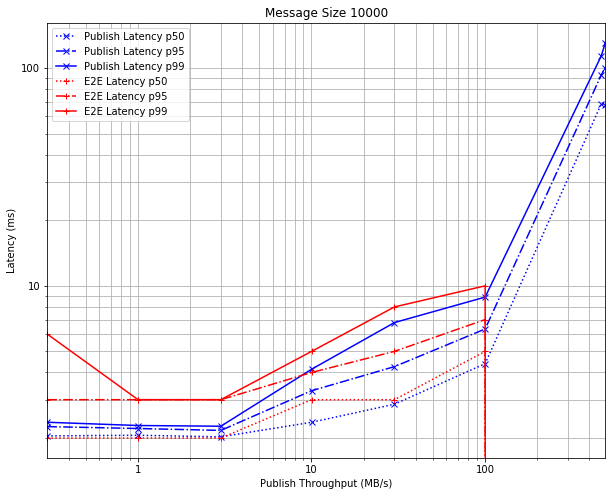

In [28]:
plot_latency_vs_throughput(filt_10000_df)

In [29]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.300573,2.046,2.257,2.363,2.0,3.0,6.0,41973e27-2801-41bd-af1f-0bb052b51417
1.002080,2.059,2.212,2.283,2.0,3.0,3.0,9b427bd4-8165-411a-9d65-11b3b5179499
3.005793,2.026,2.168,2.266,2.0,3.0,3.0,97caaa00-4add-43c0-a14b-14bf34fa2bd7
10.018248,2.362,3.298,4.139,3.0,4.0,5.0,16a17e44-1143-4e95-935c-d3c9992244f7
30.095132,2.860,4.256,6.781,3.0,5.0,8.0,9ea39cdb-d82d-49fa-911a-1f82f22f787d
100.245452,4.390,6.336,8.877,5.0,7.0,10.0,0f0874be-c493-45a6-acca-44bd16bb4dea
468.637826,68.609,93.134,113.986,0.0,0.0,0.0,6f4675d0-c3f3-46e1-80fd-6ccbf216aaca
493.887581,67.631,100.563,130.785,0.0,0.0,0.0,fe961d41-1581-4f81-a832-ebeb752f49e8


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [75]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [20]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

NameError: name 'filt_50000eps_df' is not defined

# Analyze Latency Distribution

In [21]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

NameError: name 'filt_50000eps_df' is not defined

In [22]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

NameError: name 'clean_df' is not defined

In [23]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

NameError: name 't' is not defined

In [24]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

NameError: name 'pubcdf' is not defined

NameError: name 'pubpdf' is not defined

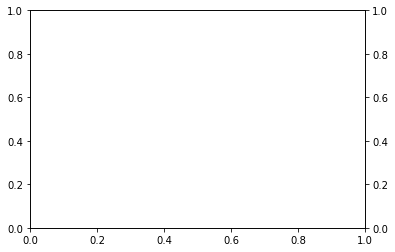

In [25]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

In [ ]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [ ]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [26]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=15,
    size_of_test_batch=(2,1000), # between
    aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=100,
    producersPerTopic=32,
    partitionsPerTopic=16,    
)
len(filt_df)

NameError: name 'clean_df' is not defined

In [27]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2361.f273314',
)
len(filt1_df)

NameError: name 'filt_df' is not defined

In [28]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='0.6.0-2386.23b7340',
)
len(filt2_df)

NameError: name 'filt_df' is not defined

In [29]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

NameError: name 'filt1_df' is not defined

In [30]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [31]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

NameError: name 'filt1_df' is not defined

In [32]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')

NameError: name 'filt1_df' is not defined